1.) What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class.

Inductive reasoning is the creation of general conclusions (or rules) based on specific observations. An example of such reasoning would be concluding that all peanuts are red, because every peanut you've ever seen is red.

Deductive reasoning is the creation of specific conclusions, based on general observations/rules. An example of such reasoning would be concluding that dolphins must have some hair/fur because all dolphins are mammals, and all mammals must have some fur.

2.) Preprocess your dataset. 

In [9]:
import pandas as pd

def create_dataframe(file: str, column_names: list[str]) -> pd.DataFrame:
    """
    Imports file into a Pandas dataframe, with specified column names
    """
    df = pd.read_csv(file, header = None)
    df.columns = column_names
    return df

file = "../Misc./adult.data"
column_names = ['age', 'work_class', 'pop_rep', 'education_lvl_cat', 'education_lvl_num', 'marital_status', 'occupation',
                'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hrs_worked_week', 'native_country', 'income']

adult_df = create_dataframe(file, column_names)
adult_df.head()

,age,work_class,pop_rep,education_lvl_cat,education_lvl_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_worked_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [19]:
from sklearn.preprocessing import LabelEncoder

def label_encode_categoricals(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Label encodes categorical columns in dataframe
    """
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    for column in columns:
        df_encoded[column] = label_encoder.fit_transform(df[column])
    return df_encoded

adult_df_encoded = label_encode_categoricals(adult_df, ['work_class', 'marital_status', 'occupation', 'relationship',
                                                        'race', 'sex', 'native_country', 'income'])

In [156]:
def count_null_values(df):
    """
    Count the number of null values in the given column(s) of a dataframe
    """
    null_counts = df.isnull().sum()
    return null_counts

null_counts = count_null_values(adult_df_encoded)
print(null_counts)

age                  0
work_class           0
pop_rep              0
education_lvl_cat    0
education_lvl_num    0
marital_status       0
occupation           0
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hrs_worked_week      0
native_country       0
income               0
dtype: int64


Hooray, no nulls to clean up!

In [161]:
def odd_character_check(df):
    """
    Checks for odd characters in string columns of a DataFrame.
    """
    weird_chars_dict = {}
    for column in df.columns:
        if df[column].dtype == 'object':
            weird_characters = df[column].str.contains(r'[^a-zA-Z0-9\s!?]', na = True)
            weird_chars_dict[column] = weird_characters.any()
    return weird_chars_dict

weird_characters_dict = odd_character_check(adult_df_encoded)
print(weird_characters_dict)


{'education_lvl_cat': True}


This is alright, given I'm not using this column, rather, its numerical counterpart, for my modelling.

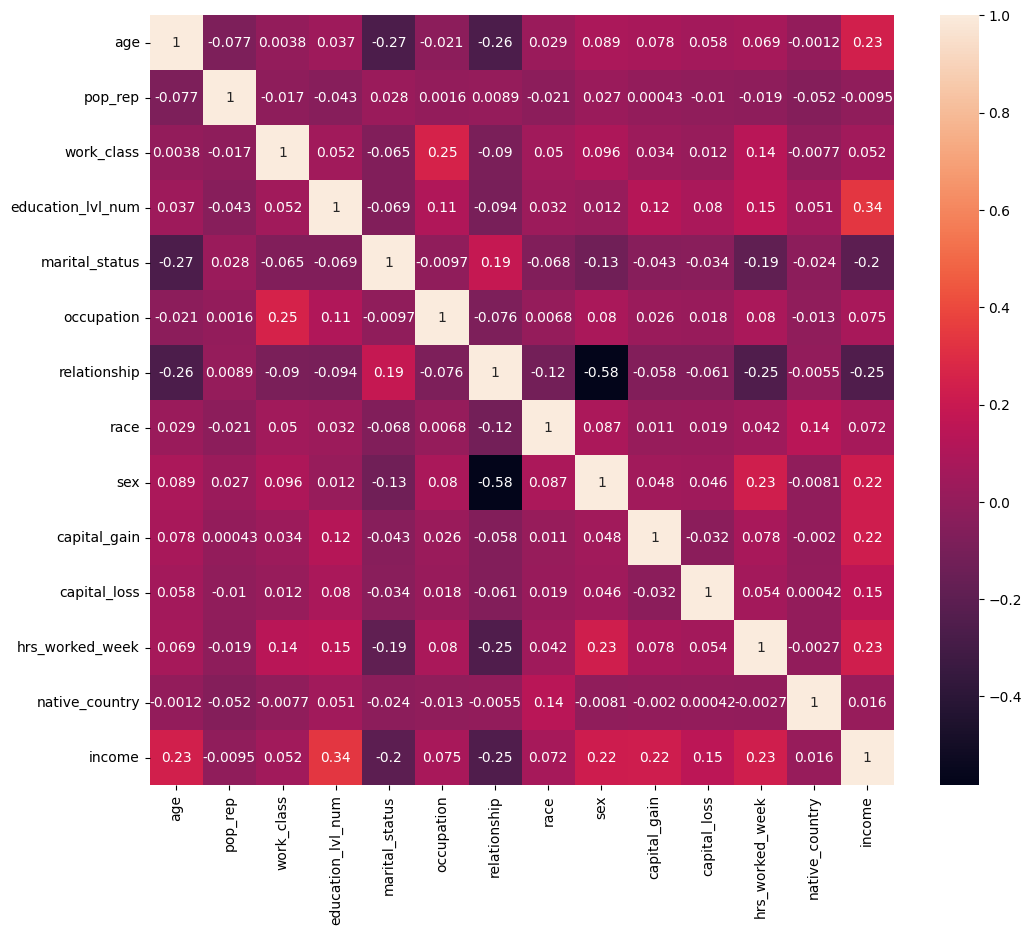

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df):
    """
    Plot a heatmap between given features of a datafrane
    """
    plt.figure(figsize = (12, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot = True)

adult_heatmap = adult_df_encoded[['age', 'pop_rep', 'work_class', 'education_lvl_num',
                                  'marital_status', 'occupation', 'relationship', 'race',
                                  'sex', 'capital_gain', 'capital_loss', 'hrs_worked_week',
                                  'native_country', 'income']]

plot_heatmap(adult_heatmap)
plt.show()

I'll drop work_class, since it has such a low collinearity with income, and is highly correlated with occupation. I'll also not consider pop_rep (it's simply a weighted measure of how much of the population a row of data represents, not useful for our purposes), and race / native country due to their incredibly low correlations, as to prevent overfitting.

In [211]:
adult_df_encoded['income'].value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

I'll be using the metrics seen below—pure precision/recall standards—due to the data's relative balance, a ratio of 3:1 >50k to <=50k, as opposed to the 1:10+ ratio characterized in class as "imbalanced", and warranting AUC / ROC evaluations.

3.) Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.

In [212]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report

def train_decision_tree(X, y):
    """
    Train decision tree using sklearn tree
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 32)
    model = tree.DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 22, random_state = 32)
    model.fit(X_train, y_train)
    return model, X_test, y_test

def evaluate_decision_tree(model, X_test, y_test):
    """
    Evaluate (given) decision tree
    """
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

X = adult_df_encoded.drop(['income', 'pop_rep', 'education_lvl_cat',
                           'occupation', 'race', 'native_country'], axis = 1)
y = adult_df_encoded['income']

model, X_test, y_test = train_decision_tree(X, y)

evaluate_decision_tree(model, X_test, y_test)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7479
           1       0.75      0.58      0.65      2290

    accuracy                           0.86      9769
   macro avg       0.82      0.76      0.78      9769
weighted avg       0.85      0.86      0.85      9769



- Increased the max_depth (number of internal nodes in a tree) from to 10
- Set the min_samples_split (minimum number of samples required in an internal node to split it) to 22
- Attempted to tune with below methods, applied to Random Forest, but those only decreased the accuracy marginally
- Used a pretty time-consuming and retrospectively inefficient, but educated guess and check method

4.) Create a random forest model tuned to the best of your abilities. Explain how you tuned it.

In [193]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def train_random_forest(X, y):
    """
    Train random forest using RandomForestClassifier
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 32)
    rf = RandomForestClassifier(n_estimators = 200, min_samples_split = 80, min_samples_leaf = 6,
                                bootstrap = True, random_state = 32)
    rf.fit(X_train, y_train)
    return rf, X_test, y_test

def evaluate_random_forest(rf, X_test, y_test):
    """
    Evaluate (given) random forest
    """
    accuracy = rf.score(X_test, y_test)
    print(accuracy)

X = adult_df_encoded.drop(['income', 'pop_rep', 'education_lvl_cat',
                           'occupation', 'race', 'native_country'], axis = 1)
y = adult_df_encoded['income']

rf, X_test, y_test = train_random_forest(X, y)

evaluate_random_forest(rf, X_test, y_test)

0.8629337700890573


- Increased number of estimators from 100 to 200: although exponentially higher numbers of estimators marginally increased the accuracy of the Forest, they weren't worth the minute-plus computation time added per thousands estimators
- Increased min_samples_split (see explanation above) to 80, coinciding rather intuitively with increasing the number of estimators
- Increased min_samples_leaf (much like samples split, except for leaf nodes) to 10
- Bootstrapped the data for a fractional increase in accuracy
- Also used a guess-and-check method, but with more ratioanle behind each change, and excluding changes which made computation times unreasonably long

5.) Create an xgboost model tuned to the best of your abilities. Explain how you tuned it.

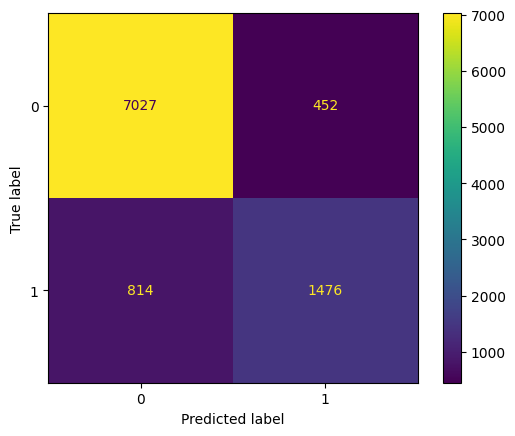

In [257]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

def train_xgboost(X_train, y_train, n_estimators = 60, max_depth = 6, learning_rate = 0.3, random_state = 32):
    """
    Train XGBoost model
    """
    xgb = XGBClassifier(n_estimators=n_estimators, max_depth = max_depth, learning_rate = learning_rate, random_state = random_state)
    xgb.fit(X_train, y_train)
    return xgb

def display_confusion_matrix(xgb, X_test, y_test):
    """
    Create confusion matrix for XGBoost using ConfusionMatrixDisplay
    """
    y_pred = xgb.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_)
    disp.plot()

xgb = train_xgboost(X_train, y_train)
display_confusion_matrix(xgb, X_test, y_test)

- Increase the number of estimators to 60, triangulated from 20 and 100, working inward
- 